## Detecting Change Over Time

In this notebook we'll learn how to threshold an image, extract features, and explore change over time. We'll begin by defining the imports we need for the analysis and a search function. The search function finds images of a given type within an AOI expressed as a bounding box (minx, miny, maxx, maxy).

In [1]:

from shapely.geometry import box, shape, Polygon
from shapely.ops import cascaded_union
from gbdxtools import Interface, CatalogImage
gbdx = Interface()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

from IPython.display import HTML, display, Image
from tempfile import NamedTemporaryFile

from skimage.transform import resize as imresize

def search(_type, bbox, clouds=10):
    aoi = box(*bbox)
    query = 'NOT item_type:IDAHOImage AND item_type:{}'.format(_type)
    query += ' AND NOT item_type:DigitalGlobeAcquisition'
    query += ' AND attributes.cloudCover_int:<={} AND attributes.bands:Multi'.format(clouds)
    res = sorted(gbdx.vectors.query(aoi.wkt, query), key=lambda x: x['properties']['item_date'])
    return [i for i in res if shape(i['geometry']).contains(aoi)]                       

### Searching for imagery

We can define an AOI and a sensor to find suitable imagery for our work. Then list the catalog ids and dates of the discovered imagery.

In [2]:
bbox = [55.2143669128418, 25.194843769649808, 55.24784088134766, 25.226527054781688]

images = search('WV02', bbox, clouds=0)

print len(images), 'Images Found'
for a in images:
    print a['properties']['attributes']['catalogID'], a['properties']['item_date'], a['properties']['attributes']['cloudCover_int']

23 Images Found
103001000226EF00 2009-12-05T06:57:22.000Z 0
1030010003539900 2010-01-12T07:11:24.000Z 0
10300100C8672200 2010-02-11T07:18:16.000Z 0
10300100030E0300 2010-02-14T07:08:25.000Z 0
1030010006CC2B00 2010-08-14T07:15:58.000Z 0
103001000968B700 2011-03-22T07:18:01.000Z 0
103001000A7B3E00 2011-06-04T07:13:36.000Z 0
103001000B6AF300 2011-06-20T07:28:23.000Z 0
103001000D314000 2011-08-22T07:19:08.000Z 0
103001000DAF7B00 2011-09-10T07:22:45.000Z 0
103001000EB59100 2011-11-06T07:30:39.000Z 0
103001000F2FA100 2011-12-17T07:23:57.000Z 0
10300100114DBC00 2012-04-04T07:11:59.000Z 0
1030010017349300 2012-04-28T07:28:49.000Z 0
103001001B068700 2012-10-05T07:31:02.000Z 0
103001001D400F00 2012-12-01T07:29:42.000Z 0
103001002660A000 2013-10-01T07:28:34.000Z 0
1030010027703600 2013-10-04T07:18:04.000Z 0
1030010031942A00 2014-05-15T07:05:43.000Z 0
1030010032484B00 2014-05-31T07:15:41.000Z 0
103001005E21C400 2016-09-23T07:01:08.000Z 0
1030010063A2D800 2016-12-27T06:54:59.000Z 0
1030010065777D00

### Data Prep

For this analysis we'll be using RGB images and water indices to extract land area from each of our images. This cell collects/fetches the data from GBDX and stores them for use later on. Note that the water index is calculated as the normalized difference of the first and last bands of our imagery. 

In [ ]:
water = []
rgbs = []
catalog_images = []

for img in images:
    try:
        i = CatalogImage(img['properties']['attributes']['catalogID'], bbox=bbox)
        catalog_images.append(i)
        rgbs.append(i.rgb())
        data = i.read().astype(np.float32)
        water.append((data[7,:,:] - data[0,:,:]) / (data[7,:,:] + data[0,:,:]))
    except Exception as err:
        print err

Fetching Image... 56 tiles


### Exploring the data

Before we begin exploring each image we can plot both the RGB and water index of the first and last images. This gives us a look at the total difference between our data.

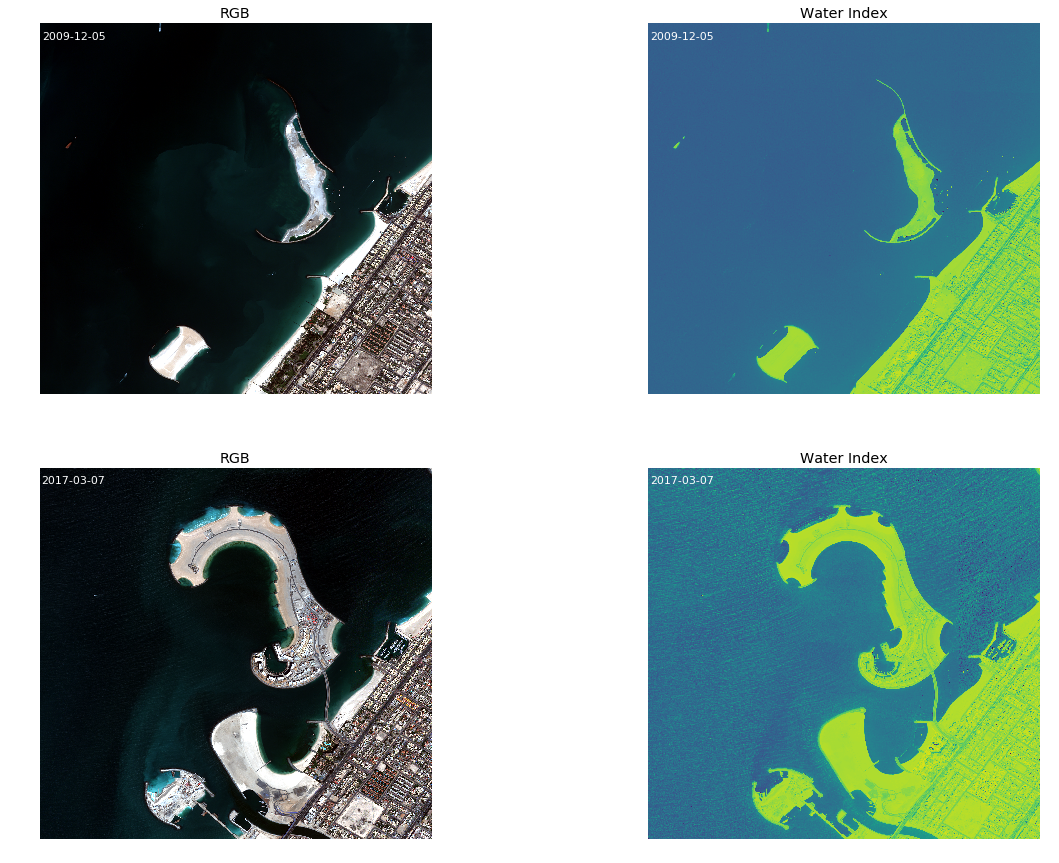

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


plt.figure(figsize=(20,15))
num = 0

for i in [0, -1]:
    num += 1
    date = images[i]['properties']['item_date']

    plt.subplot(2, 2, num)
    plt.axis('off')
    plt.imshow(rgbs[i])
    plt.text(10, 75, date[:10], fontsize=11, color='white')
    plt.title("RGB")
    
    num += 1
    plt.subplot(2, 2, num)
    plt.axis('off')
    plt.imshow(water[i], vmin=-1, vmax=1)
    plt.text(10, 75, date[:10], fontsize=11, color='white')
    plt.title("Water Index")

### Animating Images

In order to dig deeper into the imagery we can create an animated time-series movie of each image. This helps understand the overall change per image, and gives us an effective means for understanding when visual changes occurred as well as an easily sharable visualization of the data.

In [23]:
def create_movie(frames, text=None, fps=5, width=5, height=5, align=True, alphas=None):
    if text is None:
        text = ['' for s in range(len(frames))]
    ref_shape = frames[0].shape
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.axis('off')
    
    im = ax.imshow(frames[0], vmin=-1, vmax=1)
    _text = ax.text(10, 75, text[0], fontsize=11, color='white')
    im.set_clim([0,1])
    fig.set_size_inches([width,height])
    plt.tight_layout()
    
    VIDEO_TAG = """<video controls>
      <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
      Your browser does not support the video tag.
    </video>"""
    
    def anim_to_html(anim, fps=5):
        if not hasattr(anim, '_encoded_video'):
            with NamedTemporaryFile(suffix='.mp4') as f:
                anim.save(f.name, fps=fps, extra_args=['-vcodec', 'libx264'])
                video = open(f.name, "rb").read()
            anim._encoded_video = video.encode("base64")

        return VIDEO_TAG.format(anim._encoded_video)
  
    def update_img(n):
        frame = imresize(frames[n], ref_shape, order=3)
        _text.set_text(text[n])
        im.set_data(frame)
        return im

    mov = animation.FuncAnimation(fig, update_img, len(frames), interval=30, repeat=True)
    plt.close(mov._fig)
    return display(HTML(anim_to_html(mov, fps=fps)))

In [24]:
dates = [i['properties']['item_date'][:10] for i in images]
create_movie(rgbs, text=dates, fps=5, width=10, height=7)

In [25]:
create_movie([np.clip(w, -1, 1) for w in water], text=dates, fps=5, width=10, height=7)

### Extracing Features

This is the crux of the analysis. We can use the water index to detect land by applying a threshold to the indices. The `threshold` method below leverages `skimage.threshold_otsu` function to provide a binary image of land vs. water. We can use this binary image to extract geojson via `rasterio.features`. For ease of plotting and analysis we group the features for each year into a dictionary keyed by years. 

In [26]:
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import label, regionprops
from skimage import feature, morphology
from rasterio import features
from collections import defaultdict, OrderedDict

def threshold(img):
    img[np.isnan(img)] = 0
    simage = gaussian(img, preserve_range=True)
    sthresh = threshold_otsu(simage)
    return simage > sthresh

def clean(img):
    label_img = label(img, connectivity=2)
    props = sorted(regionprops(label_img), key=lambda x: x.area)
    clean = morphology.binary_closing(img)
    
    clean = morphology.remove_small_holes(clean)
    return morphology.remove_small_objects(clean,
                int(np.floor(props[-1].area)/10), connectivity=2)

def extract_features(cimg, index):
    bool_img = clean(threshold(np.clip(water[index], -1, 1))).astype(np.uint8)
    mask = bool_img != 0
    shapes = features.shapes(bool_img, mask=mask, transform=cimg.affine)
    return [shape(s) for s,v in shapes]


geojson_images = []
geojson = defaultdict(list)
for index, img in enumerate(catalog_images):
    year = img.ipe_metadata['image']['acquisitionDate'][:4]
    yr_features = extract_features(img, index)
    geojson_images.append(cascaded_union(yr_features))
    geojson[year] += yr_features

geojson = OrderedDict(sorted(geojson.items(), key=lambda t: t[0], reverse=True))

for year, f in geojson.iteritems():
    union = cascaded_union(f)
    geojson[year] = {"geometry": union.__geo_interface__}

### Interactive Map

As a quick check of the features extracted from the imagery we can plot the first and last year's data that we've extracted. This helps to ensure we're getting the expected data.

In [27]:
gbdx.vectors.map([geojson['2016']]+[geojson['2009']])

<IPython.core.display.Javascript object>

### Results

As final step we plot the results of the analysis by stacking the extracted features in one plot and plotting the total land area change over time in another. 

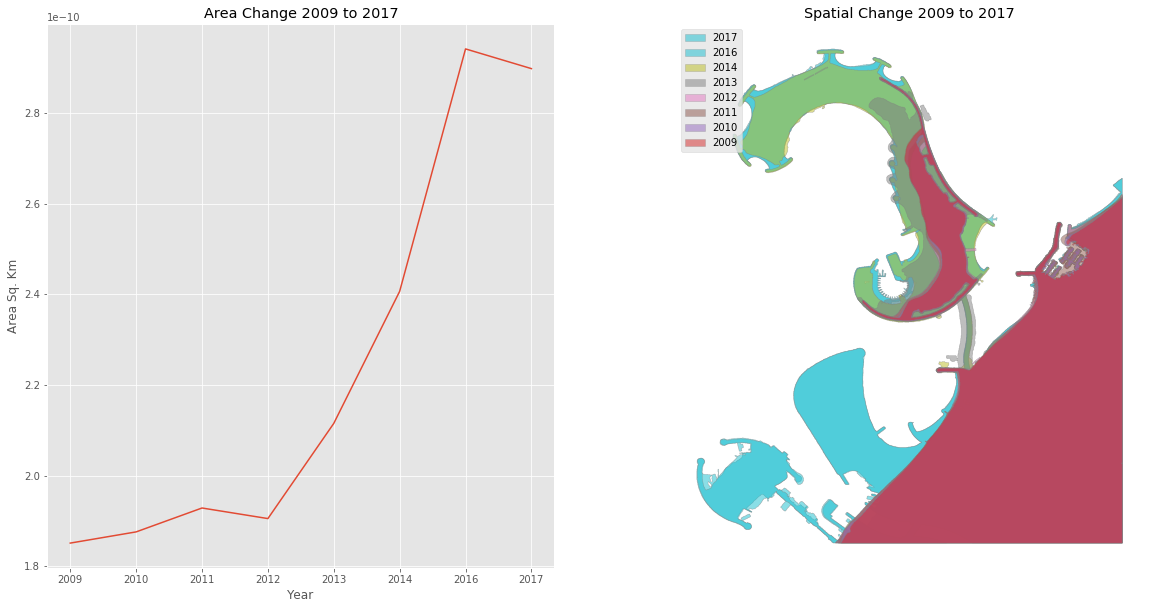

In [28]:
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
import matplotlib

plt.style.use('ggplot')
fig = plt.figure(figsize=(20,10))

cmap = matplotlib.cm.get_cmap('tab10_r')

areas = [shape(v['geometry']).area / 1000000 for k,v in geojson.items()][::-1]

plt.subplot(1, 2, 1)
plt.plot(areas)
plt.xticks(range(len(geojson.keys())), geojson.keys()[::-1])
plt.ylabel('Area Sq. Km')
plt.xlabel('Year')
plt.title('Area Change 2009 to 2017')


plt.subplot(1, 2, 2)
ax = fig.gca()
ax.axis('off')
patches = []
for i, year in enumerate(geojson.keys()):
    color = cmap(i * .095)
    patches.append(ax.add_patch(PolygonPatch(geojson[year]['geometry'], fc=color, ec='Gray', alpha=.5, zorder=2, label=year )))
ax.legend()
ax.axis('scaled')
plt.title('Spatial Change 2009 to 2017')
plt.show()